In [1]:
import os
import shutil
import random
from pathlib import Path

# -----------------------------
# SETTINGS
# -----------------------------
SOURCE_DIR = Path("C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/Original")        # your original folder
DEST_DIR = Path("C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/dataset_split")    # new folder for splits

CLASSES = ["broken", "dirty", "clean"]
SPLIT_RATIOS = (0.7, 0.15, 0.15)    # train, val, test
SEED = 42

random.seed(SEED)

# -----------------------------
# CREATE FOLDERS
# -----------------------------
for split in ["train", "val", "test"]:
    for cls in CLASSES:
        (DEST_DIR / split / cls).mkdir(parents=True, exist_ok=True)

# -----------------------------
# SPLIT IMAGES
# -----------------------------
for cls in CLASSES:
    class_path = SOURCE_DIR / cls
    images = [f for f in class_path.iterdir() if f.suffix.lower() in [".jpg", ".png", ".jpeg"]]

    random.shuffle(images)
    n = len(images)

    train_end = int(n * SPLIT_RATIOS[0])
    val_end = train_end + int(n * SPLIT_RATIOS[1])

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    def copy_files(files, split):
        for img in files:
            shutil.copy(img, DEST_DIR / split / cls / img.name)

    copy_files(train_imgs, "train")
    copy_files(val_imgs, "val")
    copy_files(test_imgs, "test")

    print(f"{cls}: total={n}, train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)}")

print("Dataset split complete!")


broken: total=1704, train=1192, val=255, test=257
dirty: total=2245, train=1571, val=336, test=338
clean: total=2130, train=1491, val=319, test=320
Dataset split complete!


In [52]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def get_datasets():
    train_raw = image_dataset_from_directory(
        "C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/dataset_split/train",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_raw = image_dataset_from_directory(
        "C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/dataset_split/val",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_raw = image_dataset_from_directory(
        "C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/dataset_split/test",
        label_mode="categorical",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Save class names BEFORE caching
    class_names = train_raw.class_names
    print("Classes:", class_names)

    # Then apply cache/prefetch
    train_ds = train_raw.cache().shuffle(500).prefetch(tf.data.AUTOTUNE)
    val_ds = val_raw.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_raw.cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds, class_names


In [63]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def build_best_model(num_classes):
    base = EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )
    base.trainable = False   # freeze base layers

    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Rescaling(1/255)(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [62]:
model.layers[2].trainable = True   # unfreeze EfficientNet

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.3423 - loss: 1.2210 - val_accuracy: 0.2802 - val_loss: 1.2190
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 401s 3s/step - accuracy: 0.7187 - loss: 0.7066 - val_accuracy: 0.3022 - val_loss: 8.8629
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8058 - loss: 0.5262 - val_accuracy: 0.3055 - val_loss: 2.4337
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 400s 3s/step - accuracy: 0.8484 - loss: 0.4333 - val_accuracy: 0.2780 - val_loss: 1.3167
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.8560 - loss: 0.3839 - val_accuracy: 0.2791 - val_loss: 1.9758


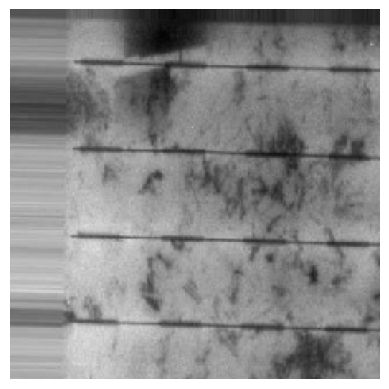

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted class: dirty
Confidence: 0.573


('dirty', 0.5729989409446716)

In [68]:
classify_image(model, "C:/Users/asus/Desktop/PV dataset/SPHERE DATASET/SPHERE DATASET/SPHERE - LABELLED DATASET/CNN_Data_Arranged/random images for check/5.jpg", class_names)
